<a href="https://colab.research.google.com/github/naenumtou/statisticalModel/blob/main/twitterIOLSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Change directory to Google Drive
%cd /content/drive/My Drive/Colab Notebooks

# Set auto reload
%reload_ext autoreload
%autoreload 2

/content/drive/My Drive/Colab Notebooks


In [ ]:
# Install libraries
!pip install --upgrade gensim #Gensim version 4.x
!pip install python-Levenshtein #For support Gensim
!pip install --upgrade pythainlp #PyThaiNLP

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import re
import string
import matplotlib as mpl
import matplotlib.pyplot as plt

from pythainlp.corpus import (thai_stopwords, 
                              thai_words,
                              thai_syllables,
                              thai_family_names,
                              thai_female_names,
                              thai_male_names)
from pythainlp.corpus.ttc import word_freqs
from pythainlp.tokenize import word_tokenize
from pythainlp.util import normalize
from collections import Counter
from gensim import corpora
from gensim.models import TfidfModel, LsiModel
from wordcloud import WordCloud

In [ ]:
# Set plot option
# Retina display
%config InlineBackend.figure_format = 'retina'

# Thai font
mpl.font_manager.fontManager.addfont('THSarabunNew.ttf')
mpl.rc('font', family = 'TH Sarabun New', size = 20)

In [ ]:
# Import dataset
df = pd.read_csv('https://raw.githubusercontent.com/naenumtou/statisticalModel/main/datasets/twitterIOTweets.csv',
                 usecols = ['tweet_text'])

# Sample dataset
df.sample(5)

,tweet_text
17219,RT @armypr_news: แถลงการณ์ นายกรัฐมนตรีกรณี สถ...
19608,@1st_Army_Area @Army4PR น่ายกย่องมาก
5135,RT @vnomenon: อุทยานแห่งชาติภูกระดึง จ. เลย ที...
3313,@teabhoky อีดอก
16480,RT @thanaaer1: นักข่าวถามเสรี พิสุทธิ์ ท่านคะใ...


In [ ]:
# Clean tweet text
# Define emoji Unicode first
emoji = re.compile("["
                   u"\U0001F600-\U0001F64F"  #Emoticons
                   u"\U0001F300-\U0001F5FF"  #Symbols & pictographs
                   u"\U0001F680-\U0001F6FF"  #Transport & map symbols
                   u"\U0001F1E0-\U0001F1FF"  #Flags (iOS)
                   u"\U00002500-\U00002BEF"  #Chinese char
                   u"\U00002702-\U000027B0"
                   u"\U00002702-\U000027B0"
                   u"\U000024C2-\U0001F251"
                   u"\U0001f926-\U0001f937"
                   u"\U00010000-\U0010ffff"
                   u"\u2640-\u2642"
                   u"\u2600-\u2B55"
                   u"\u200d"
                   u"\u23cf"
                   u"\u23e9"
                   u"\u231a"
                   u"\ufe0f"  #Dingbats
                   u"\u3030"
                   "]+", flags = re.UNICODE) #Flag option as Unicode

# Remove (.) out from punctuation string
newPunc = ''.join(set(string.punctuation) - {'.'})

# Define function for text cleansing
def cleanText(text):
  newText = re.sub(r'(?:http|ftp|https)://(?:[\w_-]+(?:(?:\.[\w_-]+)+))(?:[\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '', text) #Remove link
  newText = re.sub(emoji, '', newText) #Remove emoji
  newText = re.sub(r'@([a-zA-Z0-9_]{1,50})', '', newText) #Remove @username
  newText = re.sub(r'#([a-zA-Z0-9ก-๙_]+)', '', newText) #Remove hashtag
  newText = re.sub(r'RT', '', newText) #Remove 'RT' Word from tweet
  newText = newText.translate(str.maketrans('', '', newPunc)) #Remove punctuation without (.)
  newText = ' '.join(newText.split()) #Keep only one white space
  return newText

In [ ]:
# Apply function to clean tweet
df['cleanTweet'] = df['tweet_text'].apply(cleanText)
df = df.drop(['tweet_text'], axis = 1)

# Sample dataset
df.sample(5)

,cleanTweet
4676,เมื่อวันที่ 7 เม.ย.63 กองทัพบก ส่งแพทย์ทหาร ดู...
13683,ไงละ ประชาธิปไตยจอมปลอม
13873,หากบอกว่าสิงคโปร์รวยกว่าไทย เลยซื้อเครื่องบินไ...
1987,เชื่อมั่นในการตัดสินใจของเจ้าหน้าที่ขอให้กำลัง...
17174,ทบ.โดย กกล.ผาเมือง สกัดกั้นยาเสพติดต่อเนื่อง ล...


In [ ]:
# Word preparation
# Keep words
thaiwords = thai_words()
syllables = thai_syllables()
familyname = thai_family_names()
femalename = thai_female_names()
malename = thai_male_names()

# Remove words
# Thai stop words
stopwords = thai_stopwords()

# Thai frequency word
freqswords = word_freqs()
freq = 100 #Set frequency
freqsResults = []

for line in list(freqswords):
  if line[1] >= freq: #More than threshold means frequency
    freqsResults.append(line[0])

In [ ]:
# Tokenize tweets
words = []

for i, text in enumerate(df['cleanTweet']):
  tokenText = word_tokenize(text, engine = 'nercut', keep_whitespace = False) #Using 'nercut'
  tokenText = [normalize(word) for word in tokenText] #Normalization word
  tokenText = [word for word in tokenText if not word in stopwords] #Remove Thai stop words
  tokenText = [word for word in tokenText if not word in freqsResults] #Remove Thai frequency words
  tokenText = [word for word in tokenText if word in thaiwords or word in familyname or word in femalename or word in malename or word in syllables] #Keep Thai word and name
  words.append(tokenText)

  # Print process
  if i % 10000 == 0:
    print(f'Word processing: {i}')

# Remove empty list
cleanWords = [input for input in words if input]

# Count frequency in list of list
frequency = Counter(word for token in cleanWords for word in set(token)) 

# Remove words that appear only once
cleanWords = [
              [token for token in word if frequency[token] > 1]
              for word in cleanWords
]

Word processing: 0
Word processing: 10000
Word processing: 20000


In [ ]:
# Sample
print(f'Sample word tokenized:\n{cleanWords[:3]}')

Sample word tokenized:
[['กกต.', 'จี้', 'แจง', 'เงินกู้', 'ธนาธร'], ['อิศรา', 'ภ.ง.ด.', 'ภาษี', 'บ.', 'อุดหนุน', 'ริ', 'ล้าน'], ['เฮ้ย', 'หว่า', 'รณรงค์', 'ยกเลิก', 'เกณฑ์ทหาร']]


In [ ]:
# Topic model
# Create dictionary from text
dictionary = corpora.Dictionary(cleanWords) #Unique term
corpus = [dictionary.doc2bow(word) for word in cleanWords] #Create index of word from dictionary

# Sample
print(f'Sample word index:\n{corpus[:3]}')

Sample word index:
[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)], [(5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1)], [(12, 1), (13, 1), (14, 1), (15, 1), (16, 1)]]


In [ ]:
# Create TF-IDF Model from corpus
TFIDFModel = TfidfModel(corpus) #TF-IDF Model object
TFIDFCorpus = TFIDFModel[corpus]

# Sample
for i in range(3):
  print(f'Sample TF-IDF token {i}:\n{TFIDFModel[corpus][i]}')

Sample TF-IDF token 0:
[(0, 0.46271579113511163), (1, 0.5037995059971659), (2, 0.4312214453461676), (3, 0.41182898319028677), (4, 0.420148911779188)]
Sample TF-IDF token 1:
[(5, 0.2974710945332319), (6, 0.43316421330351507), (7, 0.3223508690123313), (8, 0.41187207816974164), (9, 0.22852633152243332), (10, 0.46956335873168176), (11, 0.42144630576029735)]
Sample TF-IDF token 2:
[(12, 0.38773478355491636), (13, 0.3389786697968141), (14, 0.5177388859878086), (15, 0.45725391814749256), (16, 0.5075632958747842)]


In [ ]:
# LSA Model
nTopics = 6 #Set number of topics

# Build model
LSIModel = LsiModel(TFIDFCorpus,
                    id2word = dictionary,
                    num_topics = nTopics,
                    decay = 0.5,
                    extra_samples = 500)

# Print topics
LSIModel.print_topics()

[(0,
  '0.998*"สุดยอด" + 0.029*"กองทัพบก" + 0.024*"ขอให้" + 0.021*"ที่พึ่ง" + 0.021*"แบบนี้" + 0.016*"ทุกท่าน" + 0.015*"ช่วยกัน" + 0.014*"นะคะ" + 0.013*"แข็งแกร่ง" + 0.012*"แก๊ง"'),
 (1,
  '-0.960*"กองทัพบก" + -0.203*"ที่พึ่ง" + -0.054*"แก้ไขปัญหา" + -0.044*"ประจำปี" + -0.039*"ผบ.ทบ." + -0.038*"แถลงการณ์" + -0.038*"จับมือ" + -0.036*"ไฟป่า" + -0.036*"หน่วยงาน" + 0.035*"สุดยอด"'),
 (2,
  '0.848*"แบบนี้" + 0.335*"ยุบ" + 0.261*"ความเสียใจ" + 0.166*"พรรค" + 0.153*"ขอให้" + 0.103*"นะคะ" + 0.097*"ผู้เสียชีวิต" + 0.059*"สูญเสีย" + -0.047*"กองทัพบก" + 0.046*"ไห้"'),
 (3,
  '0.843*"ยุบ" + 0.366*"พรรค" + -0.355*"แบบนี้" + -0.115*"ความเสียใจ" + 0.064*"พรรคอนาคตใหม่" + -0.042*"ผู้เสียชีวิต" + -0.027*"นะคะ" + 0.026*"ลงชื่อ" + -0.023*"สูญเสีย" + 0.023*"คู่มือ"'),
 (4,
  '0.817*"ความเสียใจ" + -0.358*"แบบนี้" + 0.308*"ผู้เสียชีวิต" + 0.225*"ขอให้" + 0.150*"สูญเสีย" + 0.105*"ทุกท่าน" + 0.062*"เสียชีวิต" + 0.057*"โคราช" + 0.056*"นะคะ" + 0.055*"เส"'),
 (5,
  '-0.649*"ขอให้" + -0.506*"ไห้" + -0.466*"นะคะ" 

In [ ]:
# Create summary tabel in DataFrame format
nWords = 15 #Set number of word in a topic
topicWords = None

for i, topic in enumerate(LSIModel.get_topics()):
  wordIndex = topic.argsort() #.argsort is sorting values by ascending (0 -> 1) and return index
  wordIndex = wordIndex[::-1][:nWords] #Get n index by descending order values from array
  value = topic[wordIndex] #Get values by array index
  word = [dictionary[id] for id in wordIndex] #Get word from dictionay[i], i represents index of word
  
  result = pd.DataFrame({'Topic': i + 1, 'Word': word, 'Value': value})
  if topicWords is None:
    topicWords = result.copy()
  else:
    topicWords = pd.concat([topicWords, result], axis = 0, ignore_index = True)

# Show result with pivot table
topicWords.groupby(['Topic'])['Word'].apply(lambda x: x.reset_index(drop = True)).unstack()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Topic,,,,,,,,,,,,,,,
1,สุดยอด,กองทัพบก,ขอให้,ที่พึ่ง,แบบนี้,ทุกท่าน,ช่วยกัน,นะคะ,แข็งแกร่ง,แก๊ง,ไห้,ความห่วงใย,เรย,แม่ทัพ,คับ
2,สุดยอด,แก๊ง,เรย,รต,รู้คุณ,น่าชื่นชม,ยอดเยี่ยม,เท่,ชำ,จี,หาเงิน,ถือใจ,ความสะดวก,มหาศาล,บบ
3,แบบนี้,ยุบ,ความเสียใจ,พรรค,ขอให้,นะคะ,ผู้เสียชีวิต,สูญเสีย,ไห้,ทุกท่าน,เกิดขึ้น,เหมือนกัน,โคราช,ยกเลิก,อิน
4,ยุบ,พรรค,พรรคอนาคตใหม่,ลงชื่อ,คู่มือ,ลาออก,คุก,เงินกู้,ทนาย,ไม่ต้อง,ออกมา,ปฐม,พรรคพวก,คนใน,ศาลรัฐธรรมนูญ
5,ความเสียใจ,ผู้เสียชีวิต,ขอให้,สูญเสีย,ทุกท่าน,เสียชีวิต,โคราช,นะคะ,เส,ผู้บาดเจ็บ,ได้รับบาดเจ็บ,ไห้,ทุกฝ่าย,ทุ,ห้าง
6,ความเสียใจ,แบบนี้,ผู้เสียชีวิต,ยุบ,สุดยอด,สูญเสีย,เส,เสียชีวิต,กองทัพบก,พรรค,องค์กร,ที่เกิด,เหมือนกัน,ยกเลิก,ผู้บาดเจ็บ


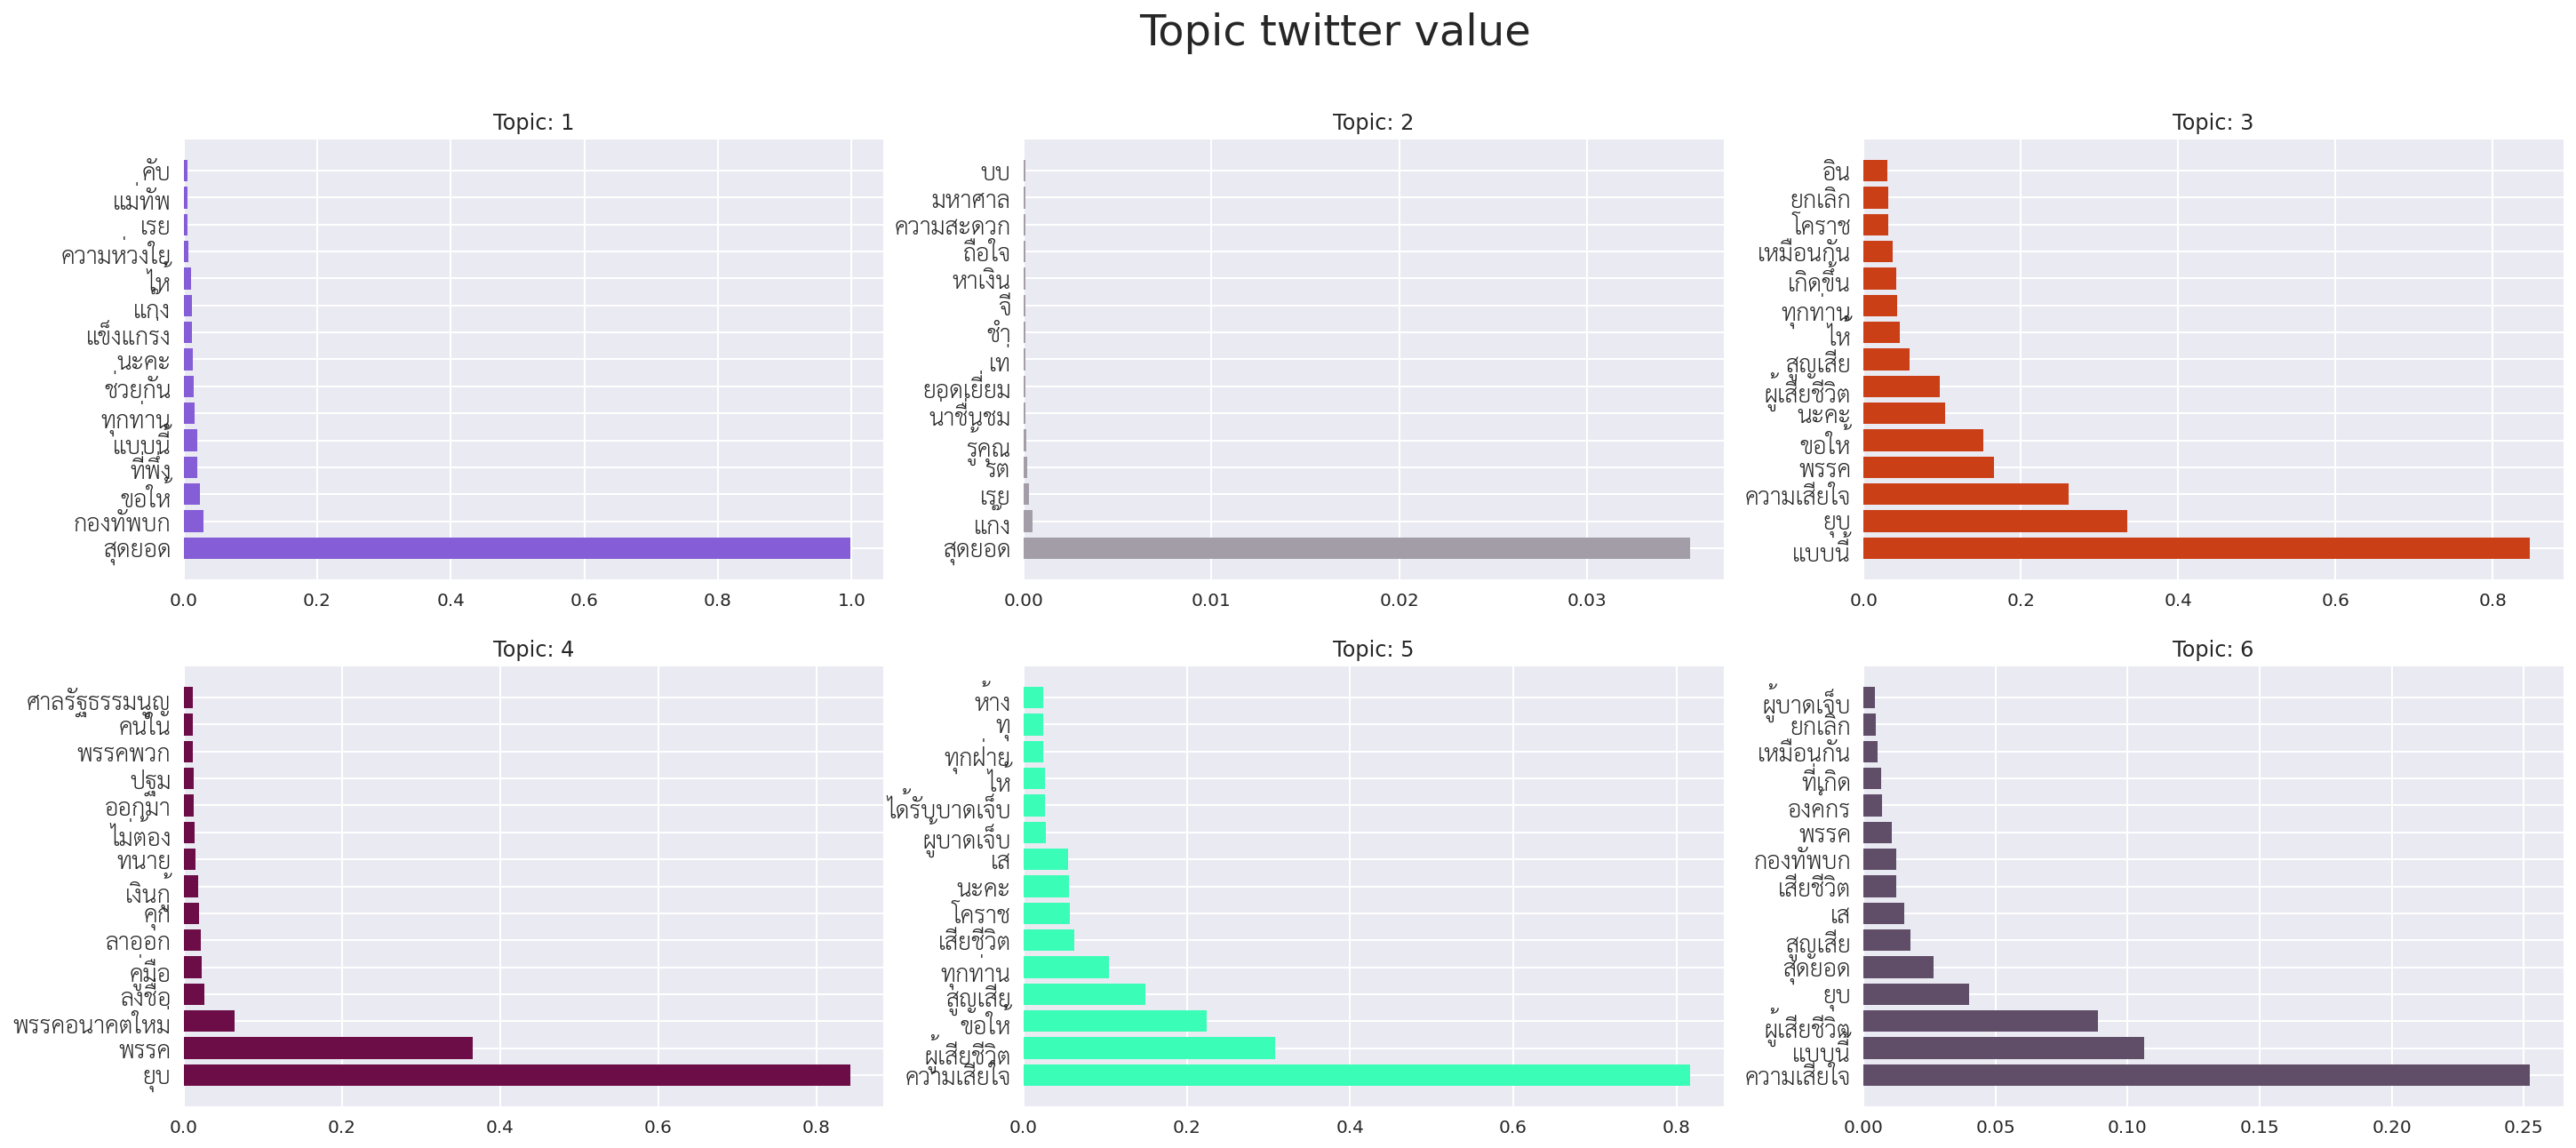

In [ ]:
# Plot values
# Define font family
axsTickFont = {'family': 'TH Sarabun New',
               'size': 20}

with plt.style.context('seaborn'):
  fig, axs = plt.subplots(int(nTopics / 3), 3, figsize = (24, 10))
  fig.suptitle('Topic twitter value')
  axs = axs.ravel()

  for i in range(nTopics):
    data = topicWords.query('Topic == @i + 1')
    value = data['Value']
    word = data['Word']
    position = np.arange(data.shape[0])
    axs[i].set_title(f'Topic: {i + 1}')
    axs[i].barh(position, value, color = np.random.rand(3))
    axs[i].set_yticks(position) #To set ticks based on number of labels
    axs[i].set_yticklabels(list(word), **axsTickFont) #**kwargs for Thai font option
plt.savefig('wordValues.png')
plt.show()

In [ ]:
# Define function word cloud
def plotWord(data):
  wordcloud = WordCloud(font_path = 'THSarabunNew.ttf',
                        width = 1200,
                        height = 800,
                        background_color = 'white',
                        regexp = r'[ก-๙]+').generate_from_text(' '.join(data))
  return wordcloud

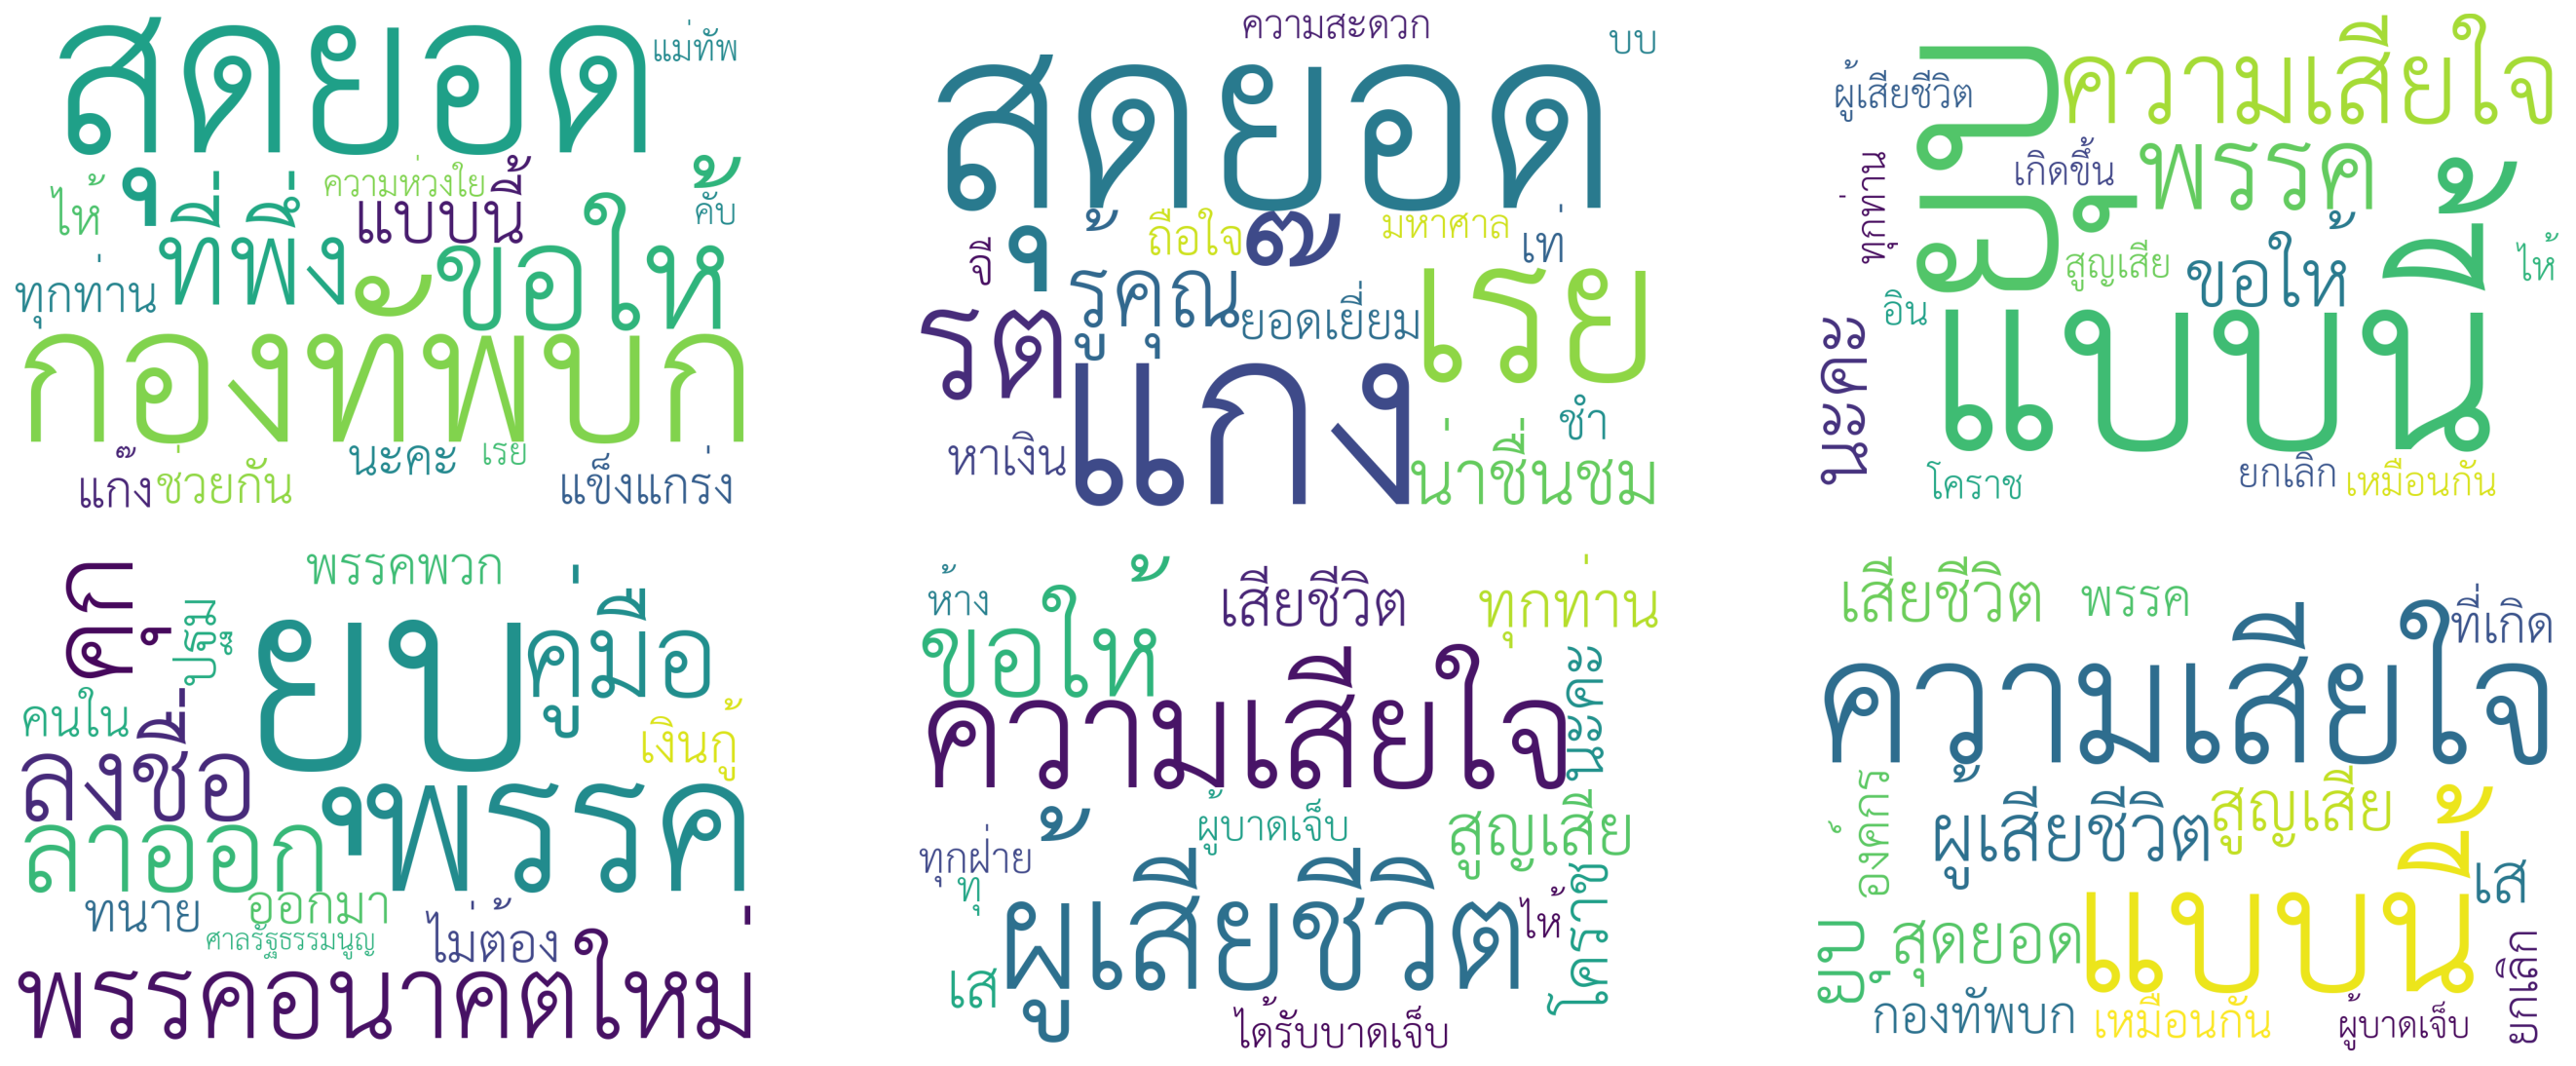

In [ ]:
# Plot word cloud
fig = plt.figure(figsize = (20, 8))

for i in range(nTopics):
  data = topicWords.query('Topic == @i + 1')['Word'] #Extract only word
  ax = fig.add_subplot(int(nTopics / 3), 3, i + 1)
  wordcloud = plotWord(data)
  ax.imshow(wordcloud)
  ax.axis('off')
fig.tight_layout()
fig.savefig('wordPlot.png')